### **Objective**

#### The objective is to understand the preference in types of road and frequency of cyclists

### **Initialization**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier

In [14]:
cyclists_df = pd.read_csv('./dataset/cyclists_cleaned.csv')

copy = cyclists_df.copy()

In [15]:
'''# Calculate the 25th percentile of races_participated
percentile_1 = copy['races_participated'].quantile(0.01)

# Filter the DataFrame
copy = copy[copy['races_participated'] > percentile_1]

percentile_2 = copy['races_participated'].quantile(0.99)

# Filter the DataFrame
copy = copy[copy['races_participated'] <= percentile_2]

# Display the filtered DataFrame
copy.describe()'''

"# Calculate the 25th percentile of races_participated\npercentile_1 = copy['races_participated'].quantile(0.01)\n\n# Filter the DataFrame\ncopy = copy[copy['races_participated'] > percentile_1]\n\npercentile_2 = copy['races_participated'].quantile(0.99)\n\n# Filter the DataFrame\ncopy = copy[copy['races_participated'] <= percentile_2]\n\n# Display the filtered DataFrame\ncopy.describe()"

Again, we select the same features used in K-mean analysis, together with 'races_participated'

In [16]:
# Select features for clustering
features = ['races_participated', 'average_race_length', 'average_climb_length', 'average_intensity']
feature_data = copy[features]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(feature_data)

# Convert back to a DataFrame for clarity
scaled = pd.DataFrame(scaled, columns=features)

### Find the initial value eps

#### **KNN** Method

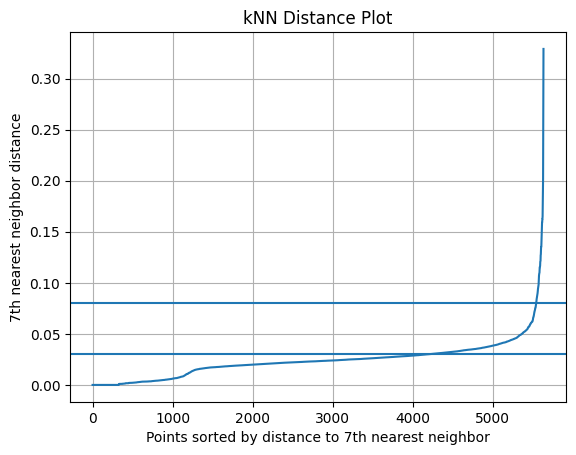

In [17]:
min_samples = 2 * len(features)
# Compute k-nearest neighbors
k = min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(scaled)
distances, indices = nbrs.kneighbors(scaled)

# Sort the distances to find the elbow
distances = np.sort(distances[:, k - 1])  # Sort by k-th nearest distance
plt.plot(distances)
plt.xlabel("Points sorted by distance to {}th nearest neighbor".format(k))
plt.ylabel("{}th nearest neighbor distance".format(k))
plt.title("kNN Distance Plot")
plt.grid(True)
plt.axhline(0.03)
plt.axhline(0.08)
plt.show()

#### **Knee** Method

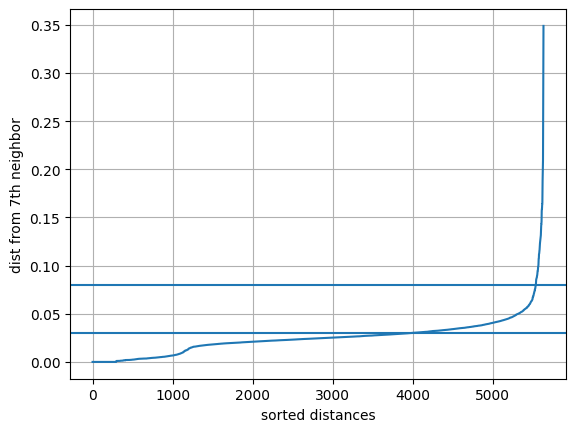

In [18]:
dist = pdist(scaled, 'euclidean')
dist = squareform(dist)
kth_distances = list()

for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, )
plt.xlabel('sorted distances', )
plt.tick_params(axis='both', which='major')
plt.grid(True)
plt.axhline(0.03)
plt.axhline(0.08)
plt.show()

### Finding the optimal results by varing *Min Sample* and *ESP*

We use Silhouette score as the metric for it measure both cohesion and separation, closer the result is to 1, the more separated are the clusters<br>
By analyzing both KNN and Knee method, we marked down the best eps value ranges from 0.04 and 0.08<br>

In [19]:
sil_list = []
db_combination = []

eps_values = np.arange(0.04, 0.09, 0.005)  
min_samples_values = range(2, 9, 1)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled)
        unique_label = np.unique(labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        silhouette = silhouette_score(scaled, labels)
        print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}, noise points: {n_noise}, silhouette: {silhouette}")
        sil_list.append(silhouette)
        db_combination.append((eps, min_samples, len(unique_label)))

eps: 0.04, min_samples: 2, clusters: 40, noise points: 105, silhouette: -0.46735334828008734
eps: 0.04, min_samples: 3, clusters: 22, noise points: 141, silhouette: -0.2522814561537956
eps: 0.04, min_samples: 4, clusters: 16, noise points: 171, silhouette: -0.22168641917120321
eps: 0.04, min_samples: 5, clusters: 15, noise points: 199, silhouette: -0.0988493634272999
eps: 0.04, min_samples: 6, clusters: 13, noise points: 248, silhouette: -0.06800258929857513
eps: 0.04, min_samples: 7, clusters: 13, noise points: 276, silhouette: -0.2632885973876119
eps: 0.04, min_samples: 8, clusters: 10, noise points: 321, silhouette: -0.050775331845544995
eps: 0.045, min_samples: 2, clusters: 30, noise points: 79, silhouette: -0.37973489228035434
eps: 0.045, min_samples: 3, clusters: 21, noise points: 97, silhouette: -0.29315427968110136
eps: 0.045, min_samples: 4, clusters: 13, noise points: 127, silhouette: -0.17915673163087167
eps: 0.045, min_samples: 5, clusters: 13, noise points: 140, silhouette

### Visual presentation of the results

[0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.08  0.085]


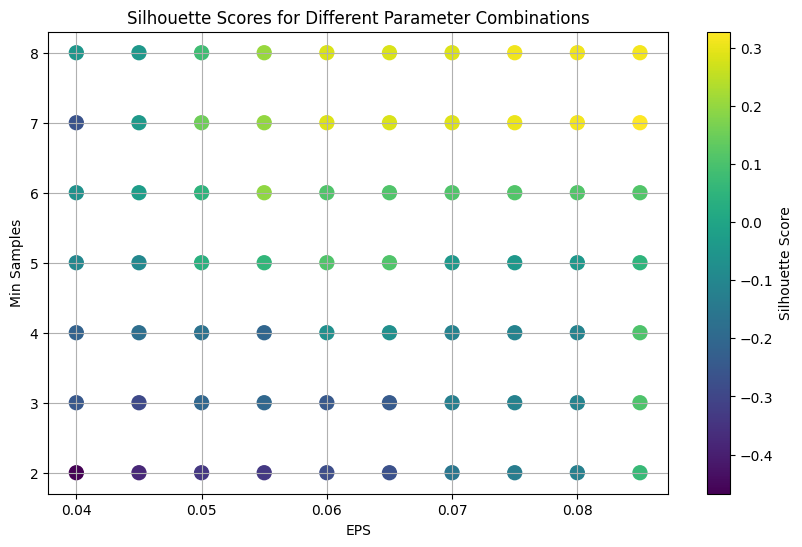

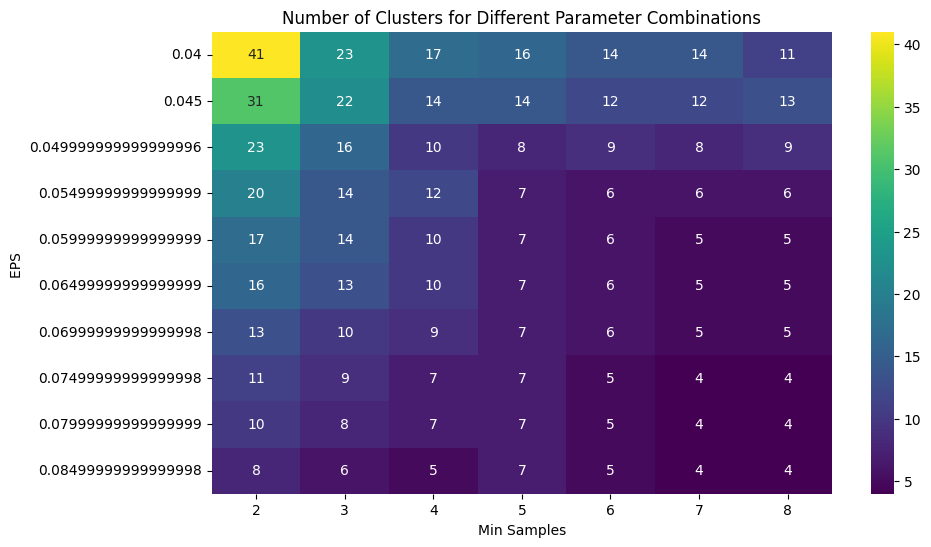

In [20]:
sil_list = np.array(sil_list)
db_combination = np.array(db_combination)
x_values = np.unique(db_combination[:, 0])
y_values = np.unique(db_combination[:, 1])
print(x_values)

plt.figure(figsize=(10, 6))
plt.scatter(db_combination[:, 0], db_combination[:, 1], c=sil_list, s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

# Initialize grid that will store the number of clusters for each parameter combination
value_grid = np.zeros((len(x_values), len(y_values)))  
for row in db_combination:
    x, y, value = row
    x_index = np.where(x_values == x)[0][0]
    y_index = np.where(y_values == y)[0][0]
    value_grid[x_index, y_index] = value  

plt.figure(figsize=(10, 6))
sns.heatmap(value_grid, xticklabels=min_samples_values, yticklabels=eps_values, cmap='viridis', annot=True)
plt.xlabel('Min Samples')
plt.ylabel('EPS ')
plt.title('Number of Clusters for Different Parameter Combinations')
plt.show()

### DBSCAN

The resulting combination of *eps* and *min_sample* are shown above, we want to use DBSCAN on the combination that produces high silhouette score and the right amount of clusters<br>
According to the graphs, combinations with eps={0.06, 0.07, 0.08} and min_sample={7, 8} produce the best results that are almost equivalent, we choose arbitrary *eps=0.07* and *min_sample=7*

C:\Users\zhuji\AppData\Local\Temp\ipykernel_16888\823446717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data['cluster_labels'] = cluster_labels


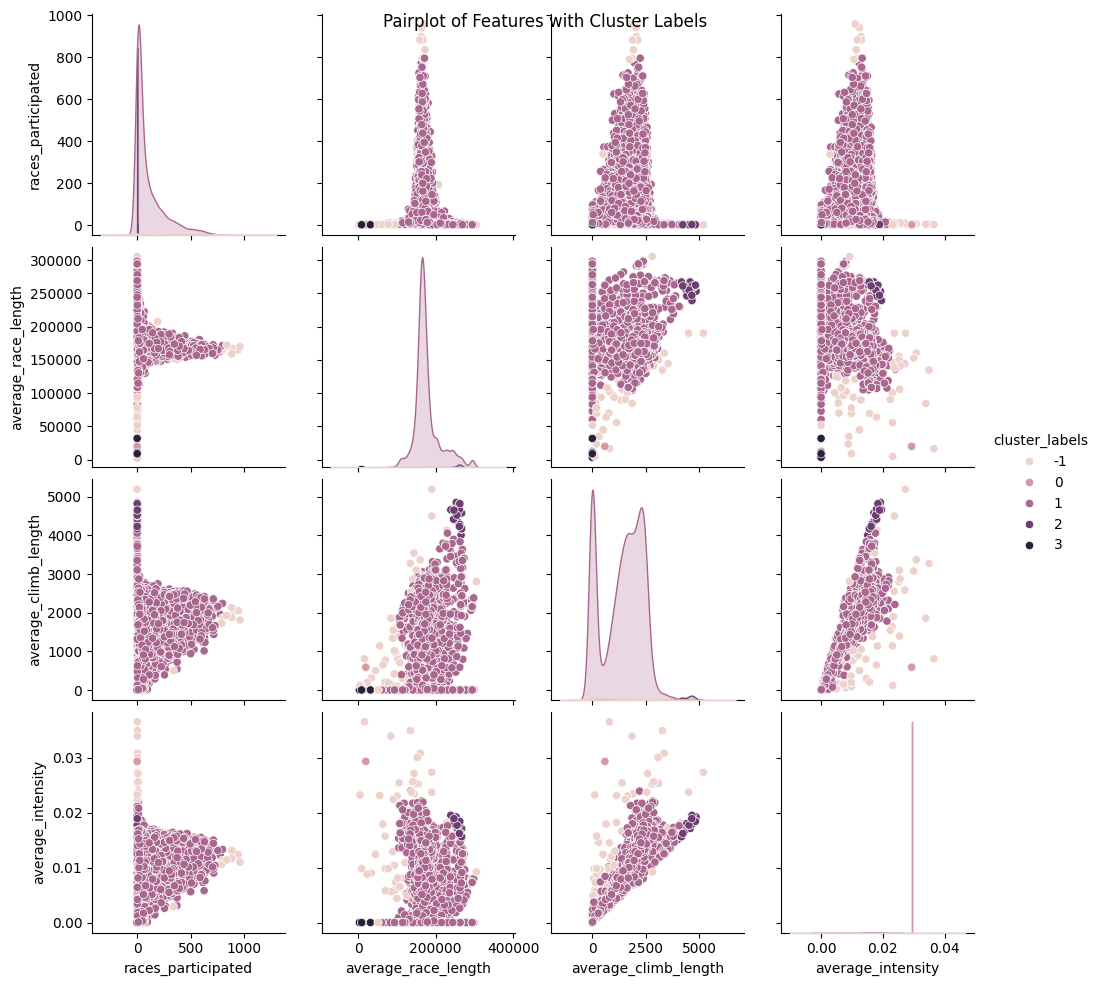

cluster_labels
 1    5496
-1      77
 2      36
 3      14
 0      12
Name: count, dtype: int64

In [21]:
dbscan = DBSCAN(eps=0.07, min_samples=7)
cluster_labels = dbscan.fit_predict(scaled)

feature_data['cluster_labels'] = cluster_labels
sns.pairplot(feature_data, hue='cluster_labels')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
feature_data['cluster_labels'].value_counts()

Here shows the results on a single cluster, for simplicity only the cluster -1 (noise/outlier) is shown

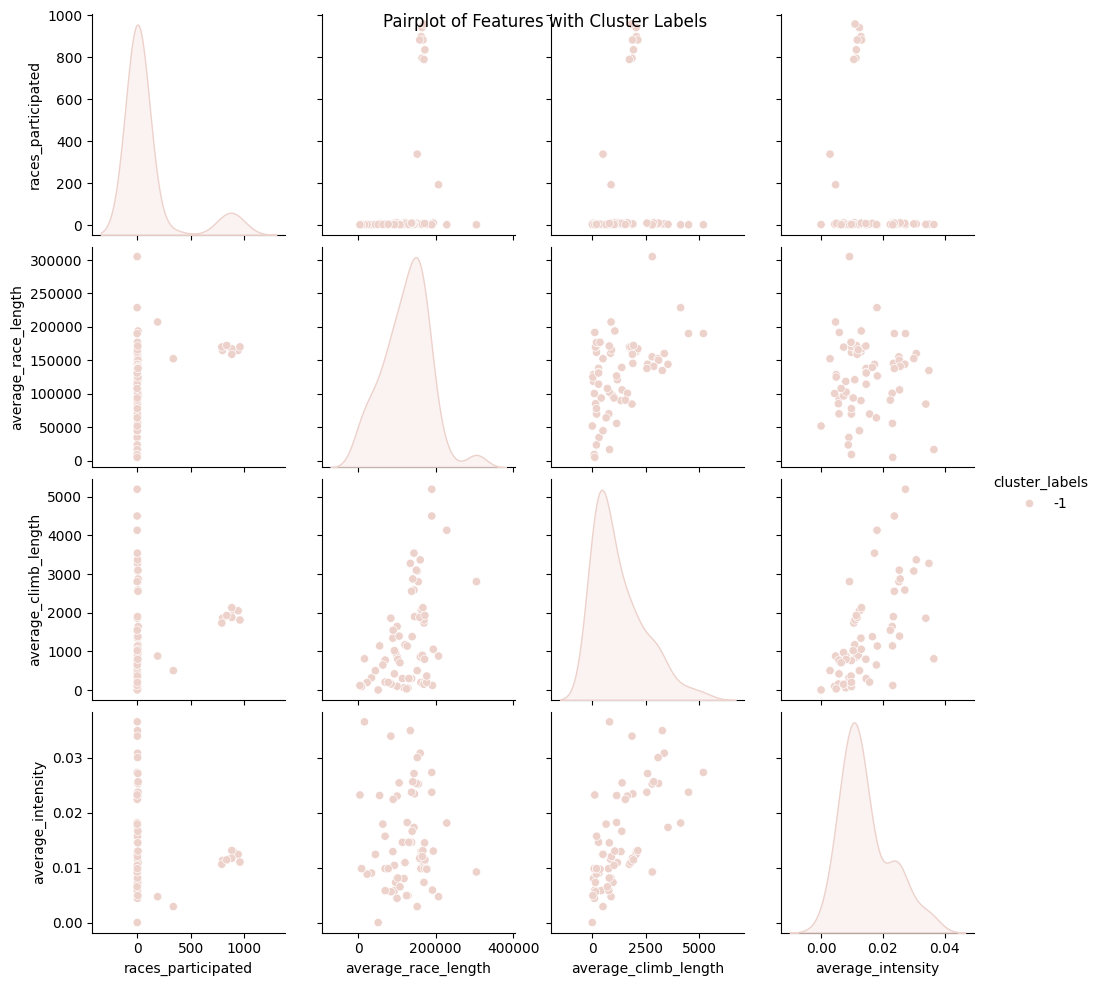

                 url_cyclist       name_cyclist  birth_year  weight  height  \
19            luc-suykerbuyk    luc  suykerbuyk        1964      77     190   
275               karl-maxon        karl  maxon        1959      65     172   
414         adelino-teixeira  adelino  teixeira        1954      72     170   
514           claudio-savini    claudio  savini        1956      67     171   
546         franco-ballerini  franco  ballerini        1964      78     185   
...                      ...                ...         ...     ...     ...   
5383            greg-gilmore      greg  gilmore        1961      64     180   
5388          lieven-malfait    lieven  malfait        1952      75     177   
5400            yuri-barinov      yuri  barinov        1955      62     180   
5418         didier-bourrier   didier  bourrier        1955      71     183   
5495  eduardo-acevedo-porras   eduardo  acevedo        1965      63     175   

        nationality   bmi  races_participated  aver

In [22]:
cluster1 = feature_data[(feature_data['cluster_labels'] == -1)]
sns.pairplot(cluster1, hue='cluster_labels')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

x = copy.loc[cluster1.index]
print(x)


Comparisons between clusters on different features

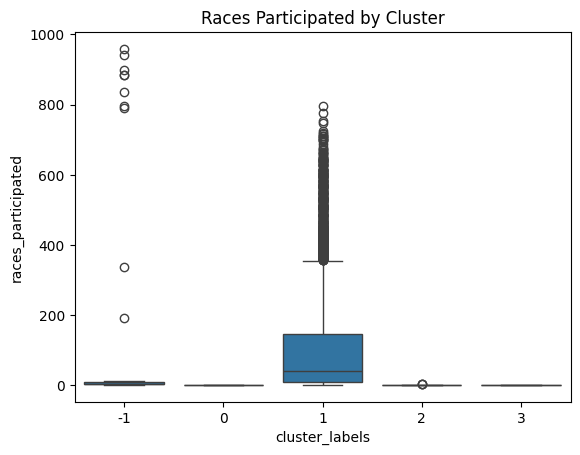

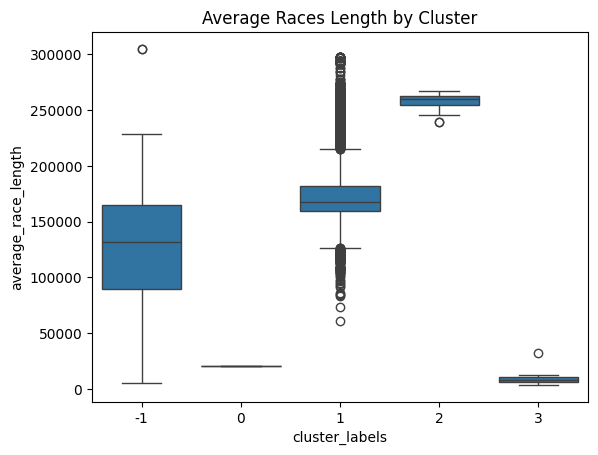

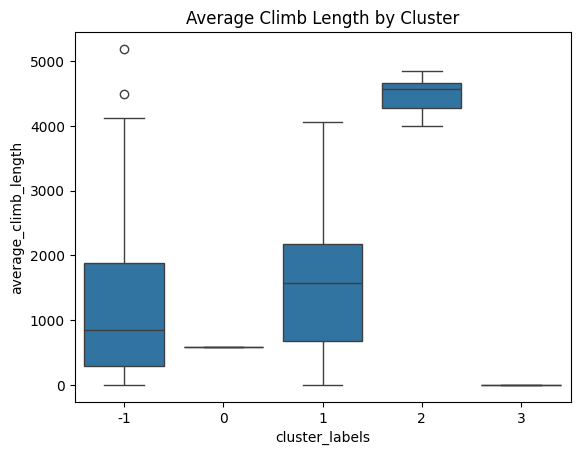

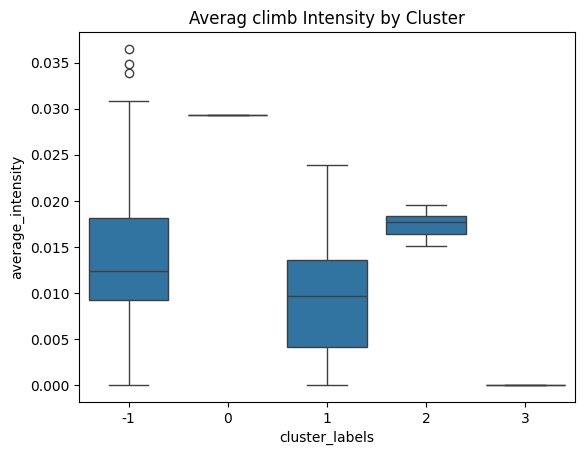

In [23]:
sns.boxplot(x='cluster_labels', y='races_participated', data=feature_data)
plt.title('Races Participated by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_race_length', data=feature_data)
plt.title('Average Races Length by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_climb_length', data=feature_data)
plt.title('Average Climb Length by Cluster')
plt.show()

sns.boxplot(x='cluster_labels', y='average_intensity', data=feature_data)
plt.title('Averag climb Intensity by Cluster')
plt.show()


### Feature importance

                Feature  Importance
2  average_climb_length    0.361105
1   average_race_length    0.318496
3     average_intensity    0.218346
0    races_participated    0.102053


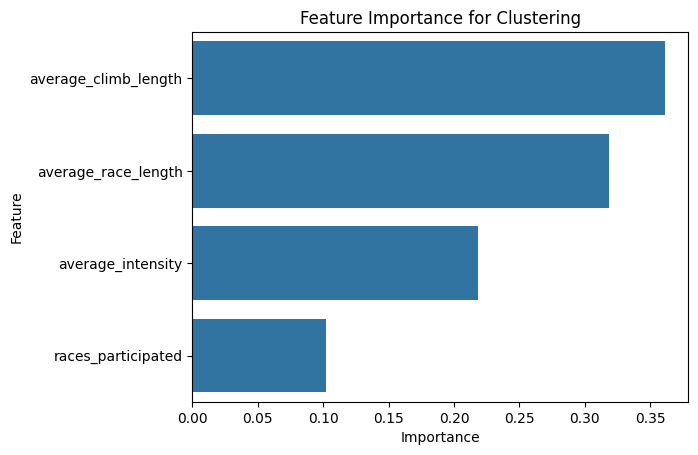

In [24]:
# Add cluster_labels to the copy DataFrame
copy['cluster_labels'] = feature_data['cluster_labels']

X = scaled[features]
y = copy['cluster_labels']

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature Importance
importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
print(importances)

# Plot Feature Importance
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance for Clustering')
plt.show()

### **Observation**
The result shows that 
- cluster **1** functions as the baseline for the dataset, where majority of cyclists belong to,they have consistant preference in road type
- cluster **0** has 12 members, acting like a singularity, after analyzing the results, we discover that this cluster has only cyclists that have run 1 specific race they are low in the races length, both on flat and inclined surface. But the race they run on has a high(er) percentage of inclined surface, this could impliy that they were a subset of specialized cyclists for the race.
- cluster **3** has 14 members, with low results on all features, we can deduce that the cyclists in this cluster are less experienced racers
- cluster **2** has 36 members, even with low participation, they achieve high results on other feature, we can categorize them as above average cyclists experienced on different type of races.
- cluster **-1** (outliers)  with 77 members, are a mix of extremely experienced cyclists with high number of race participation but below average performance, underperforming cyclists, elits cyclists and data-anomalies
